In [8]:
import sys
sys.path.append("/usr/local/lib/python3.9/site-packages")

In [9]:
import scanpy as sc
import numpy as np
import pandas as pd
from random import random
import matplotlib.pyplot as plt
from combat import combat
from sys import stderr

In [16]:
def grad_W(X,W,H):
    return -2*np.matmul(X,H.T)+2*np.matmul(W,np.matmul(H,H.T))

In [17]:
X=np.array([[1, 2,3,4], [3, 4,5,6]])
W=np.array([[1,0,0],[0,1,1]])
H=np.array([[1,1,2,3],[2,2,0,1],[1,2,3,6]])
grad_W(X,W,H)

array([[-12,  -6, -22],
       [ -2,   2,   0]])

In [3]:
print('===> Reading h5ad ...', file=stderr, flush=True)
adata = sc.read('/Users/Brainfactory/scanpy/s2-run_scanpy_pipeline/i1-adata.h5ad')

===> Reading h5ad ...


===> Reading h5ad ...
===> Convert the sparse matrix to dense array ...
===> Filtering ...
===> Normalizing per cell ...
===> Filtering based on dispersion ...


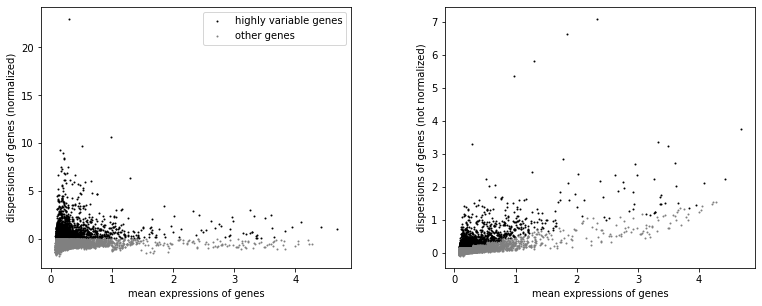

found 4 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments


Adjusting data


<Figure size 1080x360 with 0 Axes>

In [4]:
print('===> Reading h5ad ...', file=stderr, flush=True)
adata = sc.read('/Users/Brainfactory/scanpy/s2-run_scanpy_pipeline/i1-adata.h5ad')

print('===> Convert the sparse matrix to dense array ...', file=stderr, flush=True)
adata.X = np.nan_to_num(adata.X.toarray())

print('===> Filtering ...', file=stderr, flush=True)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=adata.shape[0] / 10)

print('===> Normalizing per cell ...', file=stderr, flush=True)
adata.obs['n_counts'] = adata.X.sum(axis=1)
sc.pp.normalize_per_cell(adata)

print('===> Filtering based on dispersion ...', file=stderr, flush=True)
filter_result = sc.pp.filter_genes_dispersion(adata.X, min_mean=0.0125, max_mean=999999, min_disp=0)
sc.pl.filter_genes_dispersion(filter_result)
plt.gcf().set_figheight(5)
plt.gcf().set_figwidth(15)
plt.savefig('o1-filter_genes_dispersion.png')
adata = adata[:, filter_result.gene_subset]

adata.X = combat.combat(pd.DataFrame(adata.X.T), adata.obs['label'].tolist()).T.values


In [13]:
adata

AnnData object with n_obs × n_vars = 31789 × 2438
    obs: 'label', 'prefix', 'n_genes', 'n_counts'
    var: 'Transcript stable ID', 'Transcript length (including UTRs and CDS)', 'Gene description', 'Gene % GC content', 'Transcript type', 'NCBI gene ID', 'Strand', 'HGNC symbol', 'n_cells'
    uns: 'tsne', 'label_colors'
    obsm: 'X_pca', 'X_tsne'

In [15]:
adata_sub_case_obese = adata[adata.obs['prefix'].isin(['A1', 'C1'])]

In [5]:
adata_sub_case_obese = adata

===> Computing tSNE ...
===> Generating tSNE plot ...


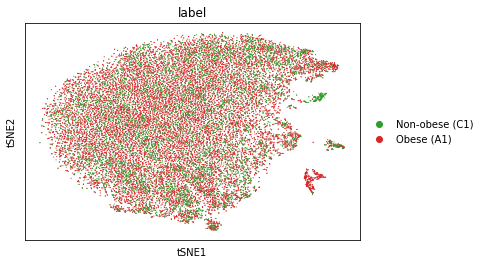

<Figure size 1080x720 with 0 Axes>

In [19]:
# print('===> Log transforming ...', file=stderr, flush=True)
# sc.pp.log1p(adata)

# print('===> Regressing ang scaling ...', file=stderr, flush=True)
# sc.pp.regress_out(adata, ['n_counts'])
# sc.pp.scale(adata)

print('===> Computing tSNE ...', file=stderr, flush=True)
sc.tl.tsne(adata_sub_case_obese)

print('===> Generating tSNE plot ...', file=stderr, flush=True)
sc.pl.tsne(adata_sub_case_obese, color='label')
plt.gcf().set_figheight(10)
plt.gcf().set_figwidth(15)
plt.savefig('reprod_o2-tsne.png')

         Falling back to preprocessing with `sc.pp.pca` and default params.


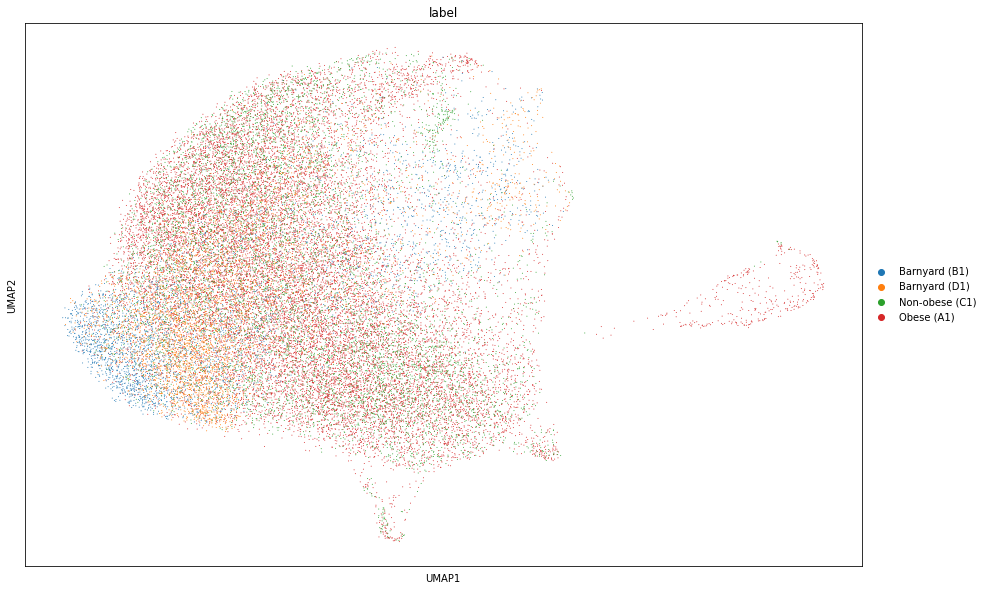

In [6]:
sc.pp.neighbors(adata_sub_case_obese, n_pcs = 30, n_neighbors = 20)
sc.tl.umap(adata_sub_case_obese)
sc.pl.umap(adata_sub_case_obese, color='label',show=False)
plt.gcf().set_figheight(10)
plt.gcf().set_figwidth(15)
plt.savefig('reprod_UMAP.png')

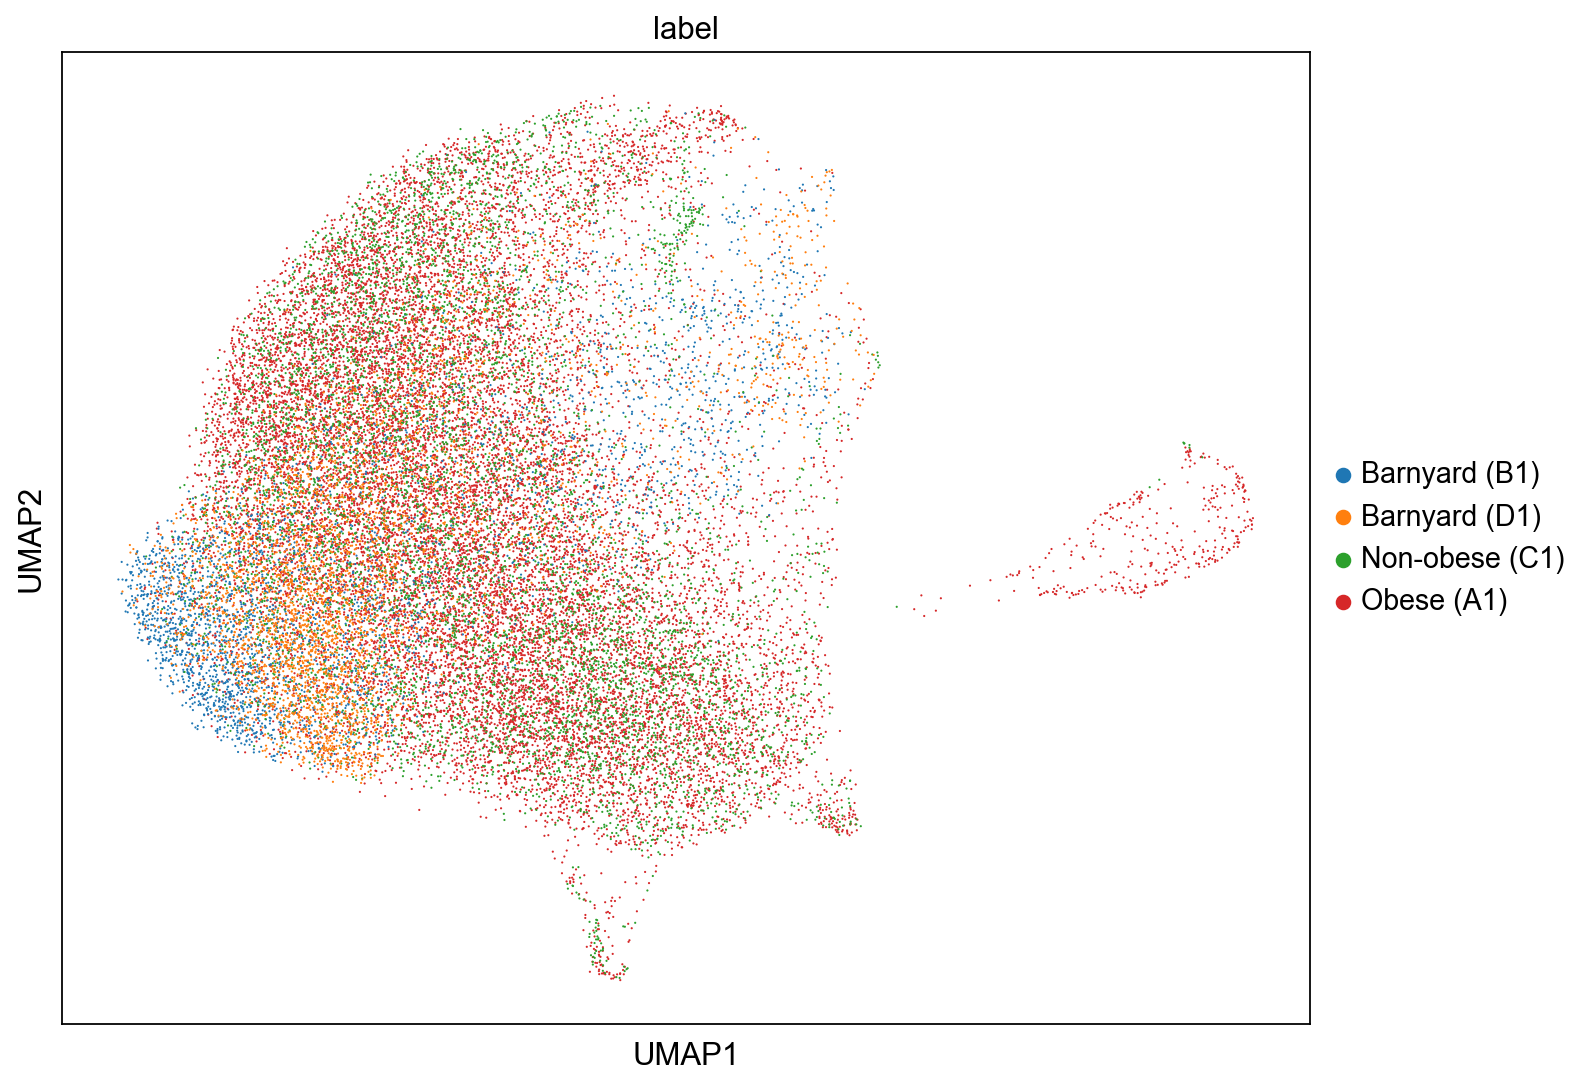

In [7]:
sc.set_figure_params(figsize=(10, 8))
sc.pl.umap(adata_sub_case_obese, color='label',save='reprod_UMAP.png')

In [ ]:
# print('===> Log transforming ...', file=stderr, flush=True)
# sc.pp.log1p(adata)

# print('===> Regressing ang scaling ...', file=stderr, flush=True)
# sc.pp.regress_out(adata, ['n_counts'])
# sc.pp.scale(adata)

print('===> Computing tSNE ...', file=stderr, flush=True)
sc.tl.tsne(adata)

print('===> Generating tSNE plot ...', file=stderr, flush=True)
sc.pl.tsne(adata, color='label')
plt.gcf().set_figheight(10)
plt.gcf().set_figwidth(15)
plt.savefig('o2-tsne.png')

print('===> Computing OPTICS ...', file=stderr, flush=True)
pycl_instance = optics(adata.obsm['X_tsne'], 1, 10)
pycl_instance.process()

# print('===> Generating OPTICS ordering ...', file=stderr, flush=True)
# ordering_analyser(pycl_instance.get_ordering())
# plt.figure()
# ordering_visualizer.show_ordering_diagram(ordering_analyser(pycl_instance.get_ordering()))
# plt.ylim(0, 2)
# plt.gcf().set_figheight(5)
# plt.gcf().set_figwidth(15)
# plt.savefig('o3-optics_ordering.png', dpi=200)

print('===> Generating OPTICS cluster assignment ...', file=stderr, flush=True)
cluster_assignment = pd.Series(['not_assigned' for _ in adata.obs.index])
cluster_idxs = sorted([x for x in pycl_instance.get_clusters() if len(x) >= 20], key=lambda x: -len(x))
cl_to_comp = {}
for i, c in enumerate(cluster_idxs):
  des = '\n'.join(['{} = {}'.format(k, v) for k, v in adata[c, :].obs['label'].value_counts().to_dict().items()])
  cl_name = 'Cluster{}'.format(str(int(i) + 1))
  cl_to_comp[cl_name] = des
  cluster_assignment[c] = cl_name
adata.obs['OPTICS Assignment'] = pd.Categorical(cluster_assignment)

print('===> Rank genes groups ...', file=stderr, flush=True)
sc.tl.rank_genes_groups(adata, 'OPTICS Assignment')

sc.pl.rank_genes_groups(adata, n_genes=20, gene_symbols='HGNC symbol')
plt.gcf().set_figheight(10)
plt.gcf().set_figwidth(23)
plt.savefig('o5-marker_genes_symbol.png', dpi=200)

sc.pl.rank_genes_groups(adata, n_genes=20)
plt.gcf().set_figheight(10)
plt.gcf().set_figwidth(23)
plt.savefig('o5-marker_eg.png', dpi=200)

print('===> Superimpose OPTICS cluster assignment on the tSNE plot ...', file=stderr, flush=True)
top_genes_recarr = adata.uns['rank_genes_groups']['names']
top_genes_vec = ['Marker genes: ' + ', '.join([adata.var['HGNC symbol'][x] for x in y]) for y in zip(*top_genes_recarr[:3].tolist())]
cl_to_top_genes = dict(zip([x[0] for x in top_genes_recarr.dtype.descr], top_genes_vec))

cluster_composition = pd.Series([cl_to_comp.get(x, '') for x in cluster_assignment])
cluster_top_genes = pd.Series([cl_to_top_genes.get(x, '') for x in cluster_assignment])
adata.obs['OPTICS Clustering info'] = pd.Categorical(cluster_assignment + '\n' + cluster_composition + '\n' + cluster_top_genes)
sc.pl.tsne(adata, legend_loc='on data', color='OPTICS Clustering info')

for c in plt.gca().collections:
  c.set_facecolor((random(), random(), random()))

# plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5), markerscale=10)
plt.gcf().set_figheight(10)
plt.gcf().set_figwidth(15)
plt.savefig('o4-optics_tsne.png', dpi=200)